## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with the nuisance parameter bias

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix


## Methods

In [2]:
def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_asimov.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-12, 2e-11)

## Import

In [3]:
config = Dataset_load.load_config()
colors = config['colors']['three']

colors
import ast

colors[1] = ast.literal_eval(colors[1])
colors[2] = ast.literal_eval(colors[2])
colors[3] = ast.literal_eval(colors[3])

### Datasets

In [4]:

dataset_asimov = Dataset_load.create_asimov(
   model = 'crab', source = "PKSflare",  parameters=None, livetime = f"1.0-hr",
)

loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz


In [5]:
norm = 0.1
tilt = 0.025
bias = 0.0
resolution = 0.0

In [6]:
setup = Setup(dataset_input=dataset_asimov)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
dataset_asimov_N.models.parameters['resolution'].frozen = True
dataset_asimov_N.models.parameters['bias'].frozen = True

dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
dataset_asimov_N.irf_model.parameters['norm'].frozen = False
setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

In [7]:
print(dataset_asimov_N.models.parameters.to_table())

    type        name       value         unit        error      min        max     frozen is_norm link     prior    
------------ ---------- ----------- -------------- --------- ---------- ---------- ------ ------- ---- -------------
    spectral      index  2.3900e+00                0.000e+00        nan        nan  False   False               None
    spectral  amplitude  3.7600e-11 TeV-1 s-1 cm-2 0.000e+00        nan        nan  False    True               None
    spectral  reference  1.0000e+00            TeV 0.000e+00        nan        nan   True   False               None
    spectral    lambda_  6.9930e-02          TeV-1 0.000e+00        nan        nan  False   False               None
    spectral      alpha  1.0000e+00                0.000e+00        nan        nan   True   False               None
     spatial      lon_0  3.2968e+02            deg 0.000e+00  3.287e+02  3.307e+02  False   False               None
     spatial      lat_0 -3.0222e+01            deg 0.000e+00 -3.

In [8]:
a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

In [9]:
%%time
fitting = 0
if fitting:
    fit = Fit(store_trace=False)
    result = fit.run([dataset_asimov])
    result_N = fit.run([dataset_asimov_N])

    dataset_asimov.models.write("data/1_model.yml", overwrite=1)
    dataset_asimov_N.models.write("data/1_model_N.yml", overwrite=1)


else:
    m = Models.read("data/1_model.yml")
    dataset_asimov.models = Models(
        [
            m[0],
            FoVBackgroundModel(
                dataset_name=dataset_asimov.name,
                spectral_model=m[1].spectral_model.copy(),
            ),
        ]
    )
    path = "data/1_model_N.yml"
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)


CPU times: user 220 ms, sys: 31.3 ms, total: 251 ms
Wall time: 360 ms


In [10]:
dataset_asimov_N

In [11]:
print("index:")
print(
    dataset_asimov.models.parameters["index"].value,
    "pm",
    dataset_asimov.models.parameters["index"].error,
)
print(
    dataset_asimov_N.models.parameters["index"].value,
    "pm",
    dataset_asimov_N.models.parameters["index"].error,
)


print("lambda:")
print(1 / 60)
print(
    dataset_asimov.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov.models.parameters["lambda_"].error,
)
print(
    dataset_asimov_N.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov_N.models.parameters["lambda_"].error,
)

print("wihtout:",
    1 / dataset_asimov.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov.models.parameters["lambda_"].error
    / dataset_asimov.models.parameters["lambda_"].value ** 2,
)
print("wiht",
    1 / dataset_asimov_N.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov_N.models.parameters["lambda_"].error
    / dataset_asimov_N.models.parameters["lambda_"].value ** 2,
)

index:
2.39 pm 0.11947704993618341
2.3923469304784004 pm 0.12020769384498718
lambda:
0.016666666666666666
0.06993006993006992 pm 0.04804165375383583
0.07010044856731333 pm 0.04843346122664301
wihtout: 14.300000000000002 pm 9.82403777612189
wiht 14.265243952608362 pm 9.856073020757002


In [12]:
print(dataset_asimov.models)
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : Crab
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.390   +/-    0.12             
    amplitude                     :   3.76e-11   +/- 3.3e-12 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.070   +/-    0.05 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : rGtsSQAh-bkg
  Datasets names            : ['rGtsSQAh']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.

In [13]:
# cutoff error in percent:
per = dataset_asimov.models.parameters["lambda_"].error/ dataset_asimov.models.parameters["lambda_"].value
print("without:",per)
per_N = dataset_asimov_N.models.parameters["lambda_"].error/ dataset_asimov_N.models.parameters["lambda_"].value
print("with:   ", per_N)

print("testL", np.sqrt(per**2 + 0.1 ** 2))

without: 0.6869956486798524
with:    0.6909151398672607
testL 0.6942355661481564


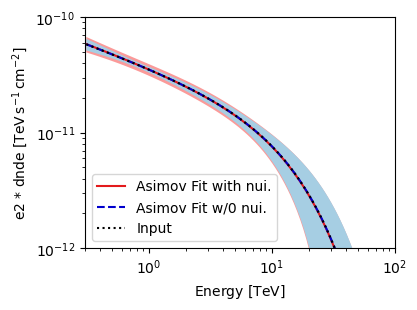

In [14]:

energy_power = 2
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
plot_asimov_spectrum(fig, axs)
axs.set_ylim(1e-12, 1e-10)

axs.set_xlim(0.3, 100)
fig.savefig("plots/asimov_crab.png")